### Data Download

In [ ]:
# RUN ONLY IF YOU DONT HAVE DATA SET YET

from zipfile import ZipFile
import os
import requests

urls = [
    "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip",
    "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
]

data_dir = "../loppuprojekti/data"
os.makedirs(data_dir, exist_ok=True)

for url in urls:
    filename = os.path.join(data_dir, os.path.basename(url))
    # Download zip file
    print(f"Downloading {url}...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print("Download ready:", filename)
    # Exctract zip file
    print(f"Extracting {filename}...")
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("Extracted files!")

print("Data pulling ready:", data_dir)

### Data Preparation

In [1]:
import random
import shutil
import os
import keras
import tensorflow as tf
from keras import ops

# For GPU logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

data_dir = "../loppuprojekti/data"
train = "../loppuprojekti/data/DIV2K_train_HR/"
validation = "../loppuprojekti/data/DIV2K_valid_HR/"
test = "../loppuprojekti/data/DIV2K_test_HR"

os.makedirs(test, exist_ok=True)

train_files = os.listdir(train)

num_test_files = int(len(train_files) * 0.15)

files_to_move = random.sample(train_files, num_test_files)

if not os.listdir(test):
    for file in files_to_move:
        src = os.path.join(train, file)
        dst = os.path.join(test, file)
        shutil.move(src, dst)

    print(f"Moved {len(files_to_move)} files to test directory")

else:
    print("Test files already exist")

2025-05-02 17:18:25.028432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746195505.047048    7134 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746195505.052823    7134 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746195505.068155    7134 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746195505.068181    7134 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746195505.068183    7134 computation_placer.cc:177] computation placer alr

Test files already exist


In [ ]:
# NOT IN USAGE | tensorflow has this dataset already
'''import os; os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras import ops

AUTOTUNE = tf.data.AUTOTUNE

div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()
# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()'''

'import os; os.environ["KERAS_BACKEND"] = "tensorflow"\n\nimport numpy as np\nimport tensorflow as tf\nimport tensorflow_datasets as tfds\nimport matplotlib.pyplot as plt\n\nimport keras\nfrom keras import layers\nfrom keras import ops\n\nAUTOTUNE = tf.data.AUTOTUNE\n\ndiv2k_data = tfds.image.Div2k(config="bicubic_x4")\ndiv2k_data.download_and_prepare()\n\n# Taking train data from div2k_data object\ntrain = div2k_data.as_dataset(split="train", as_supervised=True)\ntrain_cache = train.cache()\n# Validation data\nval = div2k_data.as_dataset(split="validation", as_supervised=True)\nval_cache = val.cache()'

#### Data Augmentation Helper Functions

In [ ]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = keras.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return ops.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            ops.flip(lowres_img),
            ops.flip(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = ops.cast(
        keras.random.uniform(shape=(), maxval=4, dtype="float32"), dtype="int32"
    )
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    high resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = ops.shape(lowres_img)[:2]  # (height,width)

    lowres_width = ops.cast(
        keras.random.uniform(
            shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype="float32"
        ),
        dtype="int32",
    )
    lowres_height = ops.cast(
        keras.random.uniform(
            shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype="float32"
        ),
        dtype="int32",
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped

def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

#### Image Augmentation Main Function

In [ ]:
def dataset_object(ds, training=True):
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=4),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds



#### Dataset Creation

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
crop_size = 96
scale = 4



import os

train_dir = os.path.join(data_dir, "DIV2K_train_HR")
val_dir = os.path.join(data_dir, "DIV2K_valid_HR")
test_dir = os.path.join(data_dir, "DIV2K_test_HR")

train_files = [
    os.path.join(train_dir, fname)
    for fname in os.listdir(train_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

val_files = [
    os.path.join(val_dir, fname)
    for fname in os.listdir(val_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

test_files = [
    os.path.join(test_dir, fname)
    for fname in os.listdir(test_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]



def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img



def random_crop_and_downscale(hr_img):
    hr_patch = tf.image.random_crop(hr_img, size=[crop_size, crop_size, 3])
    hr_patch.set_shape([crop_size, crop_size, 3])
    lr_patch = tf.image.resize(
        hr_patch, [crop_size // scale, crop_size // scale], method="area"
    )
    lr_patch.set_shape([crop_size // scale, crop_size // scale, 3])
    return lr_patch, hr_patch



# Build datasets


train_ds = tf.data.Dataset.from_tensor_slices(train_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


val_ds = tf.data.Dataset.from_tensor_slices(val_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


test_ds = tf.data.Dataset.from_tensor_slices(test_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


# Apply random cropping and downscaling
BATCH_SIZE = 8

train_sr = train_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.map(random_rotate, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.map(flip_left_right, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_sr = val_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
val_sr = val_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_sr = test_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
test_sr = test_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Example: print shapes

for lr, hr in train_sr.take(1):
    print("LR patch shape:", lr.shape)
    print("HR patch shape:", hr.shape)

I0000 00:00:1746195509.666720    7134 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6687 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:0a:00.0, compute capability: 6.1


LR patch shape: (8, 24, 24, 3)
HR patch shape: (8, 96, 96, 3)


2025-05-02 17:18:30.967025: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Plot Example of Training Data

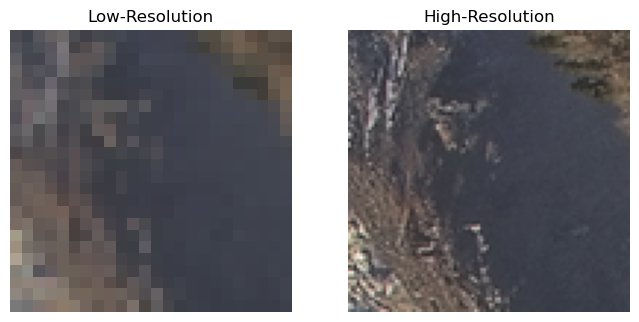

2025-05-02 17:18:31.776455: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
import matplotlib.pyplot as plt

# Get one LR-HR pair from the dataset
for lr, hr in train_sr.take(1):
    lr_img = lr.numpy()
    hr_img = hr.numpy()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Low-Resolution")
    plt.imshow(lr_img[0])
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("High-Resolution")
    plt.imshow(hr_img[0])
    plt.axis("off")

    plt.show()

#### Utility Functions

In [7]:
from keras import layers
from keras.saving import register_keras_serializable

# Utilities
@register_keras_serializable()
class PixelShuffle(layers.Layer):
    def __init__(self, scale, **kwargs):
        super().__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, block_size=self.scale)

    def get_config(self):
        config = super().get_config()
        config.update({"scale": self.scale})
        return config


@register_keras_serializable()
def PSNR(original, generated):
    return tf.image.psnr(original, generated, max_val=1.0)


def save_model(model, filepath):
    model.save(filepath)


@register_keras_serializable()
def load_model(filepath):
    return keras.models.load_model(filepath)

@register_keras_serializable()
def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)


#### Construction of Model

In [8]:
from keras import layers, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications.vgg19 import preprocess_input

# Perceptual loss with VGG
vgg = keras.applications.VGG19(include_top=False, weights="imagenet")
vgg.trainable = False
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)


def preprocess_vgg(x):
    x = tf.image.resize(x, [224, 224])
    x = preprocess_input(x * 255.0)
    return x


def combined_loss(y_true, y_pred):
    # Preprocess for VGG
    y_true_vgg = preprocess_vgg(y_true)
    y_pred_vgg = preprocess_vgg(y_pred)

    # Extract features
    f_true = vgg_model(y_true_vgg)
    f_pred = vgg_model(y_pred_vgg)

    # Perceptual loss: feature-wise MSE
    perceptual = tf.reduce_mean(tf.square(f_true - f_pred))
    pixel = tf.reduce_mean(tf.abs(y_true - y_pred))
    return 0.01 * perceptual + 1.0 * pixel


reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",  # or val_calculate_psnr for PSNR
    patience=20,
    restore_best_weights=True,
)

optimizer = Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)


# Residual block layers
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Up sampling layer
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(inputs)
    x = PixelShuffle(factor)(x)
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(x)
    x = PixelShuffle(factor)(x)
    return x


# Model creation function
def make_model(num_filters, num_of_residual_blocks):
    input_layer = layers.Input(shape=(None, None, 3))
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x, factor=2)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Activation("sigmoid")(x)
    return Model(inputs=input_layer, outputs=output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)

In [9]:

model.compile(optimizer=optimizer, loss="mae", metrics=[PSNR, SSIM])
model.fit(train_sr, validation_data=val_sr, epochs=50)
model.save_weights("mae.weights.h5")

Epoch 1/50


I0000 00:00:1746195521.177969    7191 service.cc:152] XLA service 0x7f38940523d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746195521.178056    7191 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-05-02 17:18:41.691660: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-02 17:18:42.413652: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-05-02 17:18:42.413804: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert_1/Assert
2025-05-02 17:18:42.415985: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-05-02 17:18:42.416612: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-05

 4/85 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2300 - psnr: 12.5847 - ssim: 0.4393  

I0000 00:00:1746195532.336795    7191 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.2048 - psnr: 13.1357 - ssim: 0.3339

2025-05-02 17:19:04.640827: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-05-02 17:19:04.641220: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert_1/Assert
2025-05-02 17:19:04.644264: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-05-02 17:19:04.644670: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-05-02 17:19:04.645165: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-05-02 17:19:04.645514: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_3/Assert
2025-05-02 17:19:04.767907: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.146 = (f32[8,64,24,24]{3,2,1,0}, u8[0]{0}) custom

85/85 ━━━━━━━━━━━━━━━━━━━━ 34s 179ms/step - loss: 0.2044 - psnr: 13.1486 - ssim: 0.3340 - val_loss: 0.1262 - val_psnr: 16.4940 - val_ssim: 0.4593
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - loss: 0.1149 - psnr: 17.2099 - ssim: 0.4491 - val_loss: 0.1086 - val_psnr: 17.9217 - val_ssim: 0.4765
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - loss: 0.1042 - psnr: 18.3522 - ssim: 0.4833 - val_loss: 0.1035 - val_psnr: 18.3997 - val_ssim: 0.4649
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - loss: 0.0971 - psnr: 19.1898 - ssim: 0.5111 - val_loss: 0.0872 - val_psnr: 20.4044 - val_ssim: 0.5479
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - loss: 0.0966 - psnr: 19.2992 - ssim: 0.5188 - val_loss: 0.0958 - val_psnr: 19.2817 - val_ssim: 0.5338
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - loss: 0.0935 - psnr: 19.6607 - ssim: 0.5419 - val_loss: 0.0874 - val_psnr: 19.9795 - val_ssim: 0.5362
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - loss: 0.0905 -

In [10]:
model.load_weights('mae.weights.h5')
model.compile(optimizer=optimizer, loss=combined_loss, metrics=[PSNR, SSIM])
history = model.fit(train_sr, validation_data=val_sr, epochs=50, callbacks=[early_stop])
model.save('super_resolution_model.keras')

Epoch 1/50


2025-05-02 17:31:27.879856: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-05-02 17:31:27.879996: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert_1/Assert
2025-05-02 17:31:30.704102: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.187 = (f32[8,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,224,224]{3,2,1,0} %bitcast.53462, f32[64,3,3,3]{3,2,1,0} %bitcast.53469, f32[64]{0} %bitcast.53471), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="compile_loss/combined_loss/functional_1/block1_conv1_1/convolution" source_file="/home/tensor/miniconda3/envs/tensor-g/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 839.5293 - psnr: 14.9970 - ssim: 0.3986

2025-05-02 17:31:58.529595: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.187 = (f32[4,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,224,224]{3,2,1,0} %bitcast.2973, f32[64,3,3,3]{3,2,1,0} %bitcast.2980, f32[64]{0} %bitcast.3153), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="compile_loss/combined_loss/functional_1/block1_conv1_1/convolution" source_file="/home/tensor/miniconda3/envs/tensor-g/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-02 17:31:58.721281: I external/local_xla/xla/service/gpu/autotuni

85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 203ms/step - loss: 838.3040 - psnr: 15.0058 - ssim: 0.3986 - val_loss: 633.7972 - val_psnr: 17.8959 - val_ssim: 0.4436
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - loss: 633.6099 - psnr: 18.1573 - ssim: 0.4604 - val_loss: 578.1401 - val_psnr: 17.8818 - val_ssim: 0.4806
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - loss: 626.0881 - psnr: 18.6207 - ssim: 0.4808 - val_loss: 563.5901 - val_psnr: 15.0718 - val_ssim: 0.4364
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - loss: 598.6123 - psnr: 18.4743 - ssim: 0.4681 - val_loss: 455.5249 - val_psnr: 18.3696 - val_ssim: 0.4795
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 185ms/step - loss: 584.7606 - psnr: 19.0437 - ssim: 0.4772 - val_loss: 535.5795 - val_psnr: 19.4964 - val_ssim: 0.4941
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - loss: 634.0562 - psnr: 18.8500 - ssim: 0.4600 - val_loss: 514.9913 - val_psnr: 19.9004 - val_ssim: 0.4801
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 182

In [11]:
from keras.models import load_model

# Load model THIS IS FAULTY

saved_model = load_model(
    "super_resolution_model.keras",
    custom_objects={
        "PixelShuffle": PixelShuffle,
        "combined_loss": combined_loss,
        "PSNR": PSNR,
        "SSIM": SSIM,
    },
)

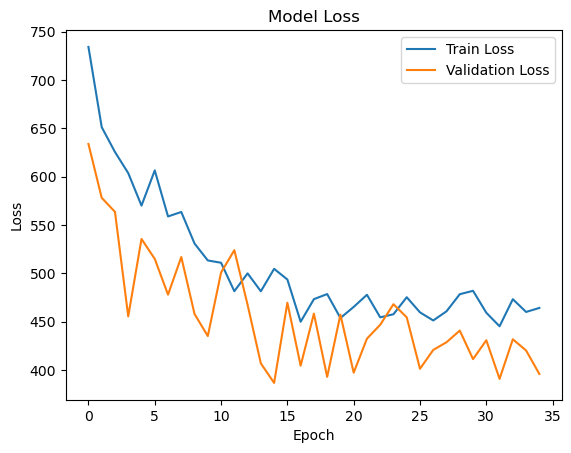

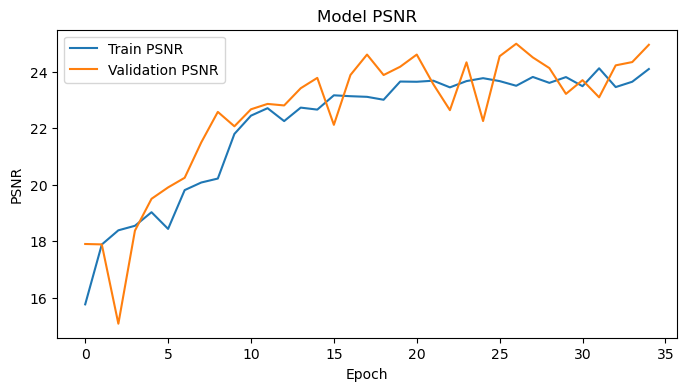

In [12]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Bigger the PSNR value is, more prediction and original high res images are same
plt.figure(figsize=(8, 4))
plt.plot(history.history['psnr'], label='Train PSNR')
plt.plot(history.history['val_psnr'], label='Validation PSNR')
plt.title('Model PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend()

plt.show()

#### Test

Testing model with full size bad quality image

2025-05-02 17:41:38.587834: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.145 = (f32[1,64,226,340]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,226,340]{3,2,1,0} %bitcast.1143, f32[64,3,3,3]{3,2,1,0} %bitcast.1150, f32[64]{0} %bitcast.1152), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_1/convolution" source_file="/home/tensor/miniconda3/envs/tensor-g/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-02 17:41:38.723521: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


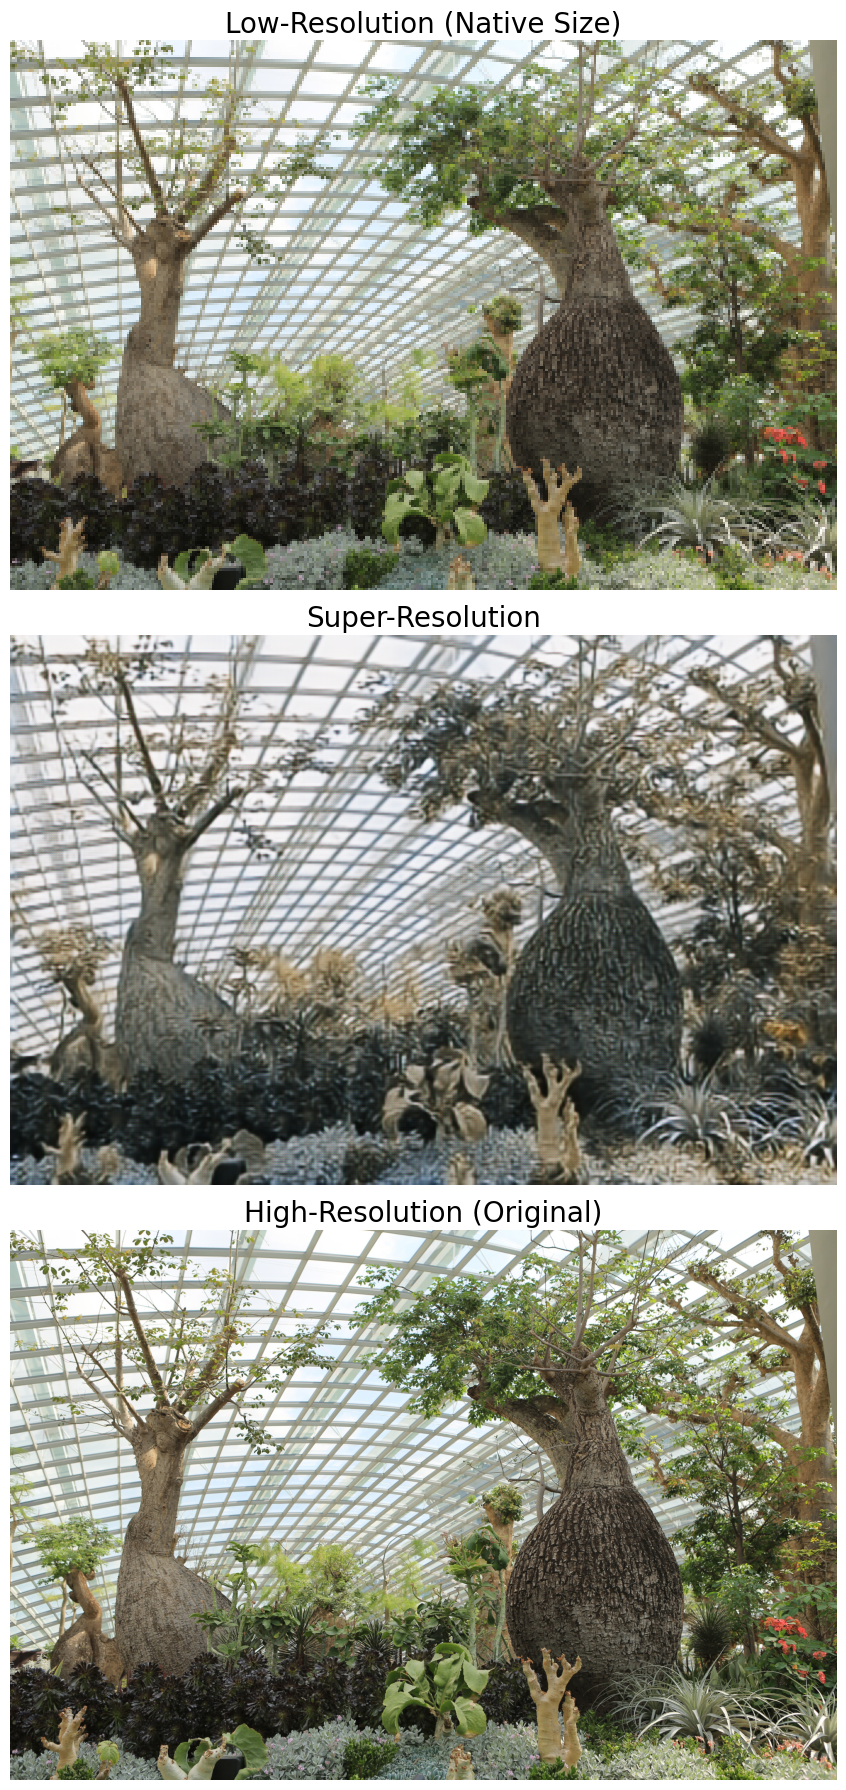

In [13]:
import numpy as np
import matplotlib.pyplot as plt


N = 7  # Index for image to take
for i, hr_img in enumerate(test_ds):
    if i == N:
        hr_img = hr_img.numpy()
        break

# Convert image to bad quality
scale = 6
h, w = hr_img.shape[0], hr_img.shape[1]
lr_img = tf.image.resize(hr_img, [h // scale, w // scale], method="area")
lr_img_blocky = tf.image.resize(lr_img, [h, w], method="nearest").numpy()

# Predict image
lr_input = tf.expand_dims(lr_img, axis=0)
sr_img = model.predict(lr_input)[0]

# Convert for display
hr_img_disp = np.clip(hr_img * 255, 0, 255).astype("uint8")
sr_img_disp = np.clip(sr_img * 255, 0, 255).astype("uint8")
lr_img_disp = np.clip(lr_img_blocky * 255, 0, 255).astype("uint8")

# Show predictions
plt.figure(figsize=(18, 18))

plt.subplot(3, 1, 1)
plt.title("Low-Resolution (Native Size)", fontsize=20)
plt.imshow(np.clip(lr_img.numpy() * 255, 0, 255).astype("uint8"), interpolation='nearest')
plt.axis("off")

plt.subplot(3, 1, 2)
plt.title("Super-Resolution", fontsize=20)
plt.imshow(sr_img_disp)
plt.axis("off")

plt.subplot(3, 1, 3)
plt.title("High-Resolution (Original)", fontsize=20)
plt.imshow(hr_img_disp)
plt.axis("off")

plt.tight_layout()
plt.show()